# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function is to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability, i.e., make the prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [2]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
from math import floor, ceil

### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html



**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- We will check the correctness of your implementation using the tests below.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [3]:
ALPHA = 1.0 # for additive smoothing

# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        mean = X.mean()
        var = np.where(X.var()==0, 1e-6, X.var())
        self.std = np.sqrt(var) 
        self.mean = mean

    def get_log_probability(self, X_new):
        
        return sp.norm(self.mean, self.std).logpdf(X_new)

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # X is a vector with binary values
        
        X = np.append(X, [0,1]) # smoothing
        self.mean = X.mean()

    def get_log_probability(self, X_new):
        
        return sp.bernoulli(self.mean).logpmf(X_new)

# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._num_of_categories = num_of_categories
        self.pre_priors = np.full(self._num_of_categories, ALPHA)
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        
        # get unique tokens and their frequencies
        tokens, counts = np.unique(X, return_counts=True)

        counts_sum = counts.sum()
        tokens_freq = dict(zip(list(tokens), list(counts)))
        self.tokens_dist = {}
        
        # calculate the frequency distribution for each category
        for t, c in enumerate(self.pre_priors):
            if t in tokens_freq:
                self.tokens_dist[t] = tokens_freq[t] + c
            else:
                self.tokens_dist[t] = c
        
        # calculate probabilities
        self.priors = np.array(list(self.tokens_dist.values())) / (counts_sum + self._num_of_categories)
        
    def get_log_probability(self, X_new):
                
        return np.log([self.priors[i] for i in X_new])

**Tests:**
    
We will use the code below to test the correctness of your code.

In [4]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [5]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [6]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.94591015 -2.1690537  -1.94591015 -2.45673577 -2.1690537  -2.86220088
 -1.94591015 -3.55534806 -2.1690537  -2.86220088]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [7]:
# Your task is to implement the three functions of NBC. 

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[]):
        self.num_features = len(feature_types)
        
        self.feature_types = feature_types
        
        self.param = {}
        
        
    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        
        # set classes using the labels
        classes = np.unique(y)
        self.num_classes = len(classes)
        self.classes = classes

        
        p = []
        for c in self.classes:
            self.param.update({c: {}})
            
            # get frequency of each class and add a smoothing (ALPHA)
            p.append(np.count_nonzero(y == c) + ALPHA)
            
            # get indices where data belong to this class (c)
            indices = np.argwhere(y==c)
            
            # get data from the found indices
            rows = X[indices.squeeze()]
            
            # for each feature (column) create the appropriate 
            # object to estimate its parameters
            # if 'r' then continuous
            # if 'b' then binary
            # if 'c' then categorical
            for k in range(self.num_features):
                if self.feature_types[k] == 'r':
                    self.param[c].update({k: ContFeatureParam()})
                elif self.feature_types[k] == 'b':
                    self.param[c].update({k: BinFeatureParam()})
                else:
                    # number of categories for the categorical:
                    # max is used just in case of having as an example: [0, 2 ,3, 5]
                    # then 5 is going to be taken and include 4,
                    # + 1 because '0' is included as a number so we need 
                    # 6 probabilities to be estimated
                    num_categories = np.max(X[:,k]) + 1
                    self.param[c].update({k: CatFeatureParam(num_categories)})
                self.param[c][k].estimate(rows[:,k])
        
        # prior probabilities
        self.class_prob = np.log(np.array(p) / (len(y) + ALPHA * self.num_classes))
        
        
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        prob = np.zeros((self.num_features, len(X)))
        posterior = np.zeros((self.num_classes, len(X)))

        for c in self.classes:
            
            # calcuate probabilities for each feature in this class (c)
            for k in range(self.num_features):
                prob[k] = self.param[c][k].get_log_probability(X[:,k])
                
            # estimate MLE by multiplying all the features 
            # for each document being in this class and 
            # multiply by the prior for this class 
            # ---> BUT ***
            # ADDITION is used since the probabilities are in log form
            # instead of multiplication
            posterior[c] = self.class_prob[c] + np.sum(prob, axis=0)

        return np.argmax(posterior, axis=0)
        

**Tests**

We will use the code below to check your code.

In [8]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)

yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)

Accuracy: 0.9333333333333333
[2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [9]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('./datasets/binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)

yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0]


In [10]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('./datasets/categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat) 

Accuracy: 0.6896551724137931
[0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]


## Logistic Regression

For logistic regression, you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [189]:
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.preprocessing import LabelEncoder

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [178]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    
    # split data to train and test
    Xtrain, ytrain, Xtest, ytest = split_data(X, y, 0.8)
    
    tst_errs_nbc = np.zeros(num_splits)
    tst_errs_lr = np.zeros(num_splits)

    for r in range(num_runs):
        for s in range(1, num_splits+1):
            
            # ratio for the cut off
            ratio = s / num_splits
            
            # cut train data 
            X_train, y_train, _, _ = split_data(Xtrain, ytrain, ratio)
            
            # initialise models by copying from the arguements
            nbc_model = nbc
            lr_model = lr
            
            # naive bayes
            nbc_model.fit(X_train, y_train) # train model
            nbc_res = nbc_model.predict(Xtest) # make predictions
            nbc_error = 1 - np.mean(nbc_res == ytest) # get error rate from predictions
            
            # logistic regression
            lr_model.fit(X_train, y_train)
            lr_res = lr_model.predict(Xtest)
            lr_error = 1 - np.mean(lr_res == ytest)
            
            # store errors
            tst_errs_nbc[s-1] += nbc_error
            tst_errs_lr[s-1] += lr_error
    
    # average the results
    tst_errs_nbc = tst_errs_nbc / num_runs
    tst_errs_lr = tst_errs_lr / num_runs
    
    return tst_errs_nbc, tst_errs_lr


In [179]:
def makePlot(nbc_perf, lr_perf, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

In [307]:
def split_data(X, y, coeff):
    """
    Arguements:
    X: data
    y: labels
    coeff: it is the coefficient that determines 
           the split of training and test data
        
    **********************************************************************
    
    this method splits data so that all classes 
    are included in train and test sets
    Also the data are shuffled
    
    e.g.
    coeff = 0.8
    classes = 0 & 1
    Then: 
    training data contains: 80% of data belonging to class 1 and 80% of data belonging to class 0
    testing data contains: 20% of data from class 1 and 20% of data from class 0
    
    This way both sets have data from all classes and maintains a split ratio of 80%/20%
    Also the class distribution is maintained in both sets
    """
    unique_classes = np.unique(y)    

    Xtrain = []
    ytrain = []
    Xtest = []
    ytest = []

    for c in unique_classes:
        # get indices of data in this class
        indices = np.argwhere(y==c).flatten()
        
        # number of training data using the coefficient
        Ntrain = int(coeff * len(indices))
        
        # shuffle data
        shuffler = np.random.permutation(len(indices))
        
        # training set and training labels
        Xtrain.extend(X[indices[shuffler[:Ntrain]]])
        ytrain.extend(y[indices[shuffler[:Ntrain]]])

        # testing set and testing labels
        Xtest.extend(X[indices[shuffler[Ntrain:]]])
        ytest.extend(y[indices[shuffler[Ntrain:]]])
    
    return np.array(Xtrain), np.array(ytrain), np.array(Xtest), np.array(ytest)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers, e.g., handle missing values, handle text/categorical data, etc.
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

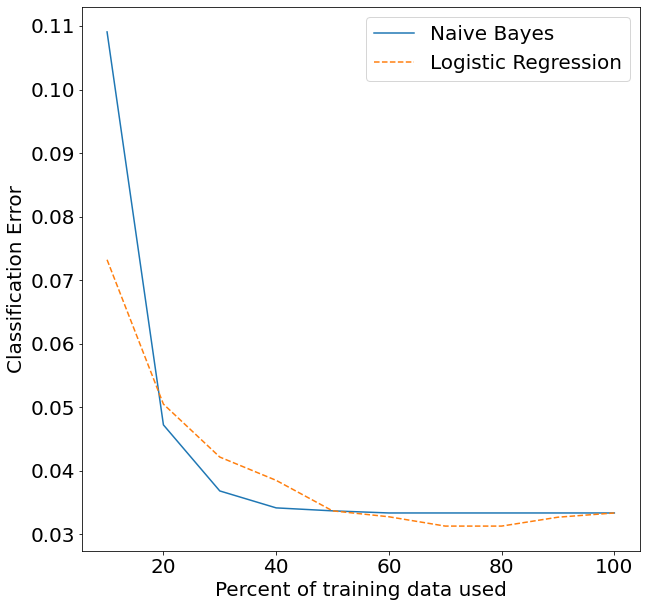

In [308]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

nbc = NBC(feature_types=['r'] * 4)
lr = LogisticRegression(max_iter=200)
nbcres, lrres = compareNBCvsLR(nbc, lr, X, y, num_runs=500)
makePlot(nbcres, lrres)


In [309]:
nbcres, lrres

(array([0.10906667, 0.0472    , 0.0368    , 0.03413333, 0.03366667,
        0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333]),
 array([0.0732    , 0.05046667, 0.04213333, 0.03846667, 0.03366667,
        0.03273333, 0.03126667, 0.03126667, 0.03266667, 0.03333333]))

**Short Report**

For pre-processing the data no step was taken. Moreover, the splitting of the data was performed in a way that the class distribution was conserved for both training and test datasets, and all the classes are included in both training and test datasets. The dataset consisted of continuous data.

Through the comparison, it can be observed that Logistic Regression managed to achieve the lowest error (0.031), using 70% of the training data. After that, a slight increase can be seen, this might be due to slight overfitting on training data. On the other hand, Naive bayes. after using 50% of the training data there was no change. This might be due to underfitting so no matter how increase in the dataset size, there is no change (high bias).

All in all, Naive Bayes had a more abrupt decrease in error when increasing the dataset size in early stages. But, Logistic Regression had a more gradual decrease in error but achieved a lower error eventually. Logistic Regression can achieve better results using very small dataset (10-20% of training data). But using the whole dataset, both classifiers achieved the same error.

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. To see it clearer, you should use only 100 data points from the dataset for this experiment.

In [257]:
def clean_data(data):
    """
    This method will:
    - encode the labels
    - remove the nan values and replace them with appropriate value
    
    For each class, and then for each column, the frequency for each value is measured
    Then for the particular class, in that column, nan is replaced by the value that 
    for that class and column exists most
    """
    le = LabelEncoder()
    le.fit(data['label'])
    datav['label'] = le.transform(data['label'])

    attr_dict = {}
    clean_data_dataframes = {}
    unique_labels = np.unique(data['label'])


    for c in unique_labels:
        # create DF for this class
        clean_data_dataframes[c] = pd.DataFrame()
        
        # get records belonging in this class
        datasubset = data[data.label == c]
        
        # for each column replace nan to value that exists most
        for column in datasubset.drop('label', axis=1).columns:
            # get frequencies for each value
            cc = Counter(datasubset[column])
            max_attr = max(cc.items(), key=lambda x: x[1])[0] # get most frequent
            # replace nan with value that has most frequency
            clean_data_dataframes[c][column] = datasubset[column].fillna(max_attr)
            clean_data_dataframes[c]['label'] = c

    # return a DF that is concatinated with all classes
    return pd.concat([clean_data_dataframes[c] for c in unique_labels])

In [267]:
def encode_columns(data):
    """
    encodes values in each column
    Since the values are either 'y' or 'n'
    then we map:
    'n' to value 0
    'y' to value 1
    """
    dataset_col = data

    for column in dataset_col.drop('label', axis=1).columns:
        data[column] = data[column].map({'n': 0, 'y': 1})

    return data

In [312]:
voting = pd.read_csv('./datasets/voting.csv')
voting = voting.sample(frac=1) # shuffle dataset

# only 100 records will be used for this task
# so it is going to be attempted to take 50 for each label
dem_data = voting[voting.label == 'democrat'].iloc[:50] # retrieve democrat data
rep_data = voting[voting.label == 'republican'].iloc[:50] # retrieve republican data

print('In new dataset:')
print('Number of democrat records:',dem_new_len)
print('Number of republican records:',rep_new_len)

datav = dem_data.append(rep_data) # concatinate democrats and republicans
datav = clean_data(datav) # remove nan values and encode label
datav = encode_columns(datav) # encode values of each column


In new dataset:
Number of democrat records: 62
Number of republican records: 38


In [313]:
datav

,handicapped-infants,label,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
320,0,0,1,1,0,0,1,0,1,1,1,0,0,1,1,0,1
180,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,1,1
47,1,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1
161,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,0,1
172,0,0,1,1,0,0,0,1,1,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,1,1,0,0,1,1,1,0,0,0,1,0,1,1,1,0,0
228,0,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
347,1,1,0,0,1,1,1,0,0,0,1,0,1,1,1,0,0
217,0,1,1,0,1,1,1,0,0,0,1,0,1,1,1,0,0


In [314]:
xdata = datav
xdata = xdata.drop('label', axis=1)
number_of_columns = len(xdata.columns)
X = xdata.to_numpy()
y = np.array(datav.label)


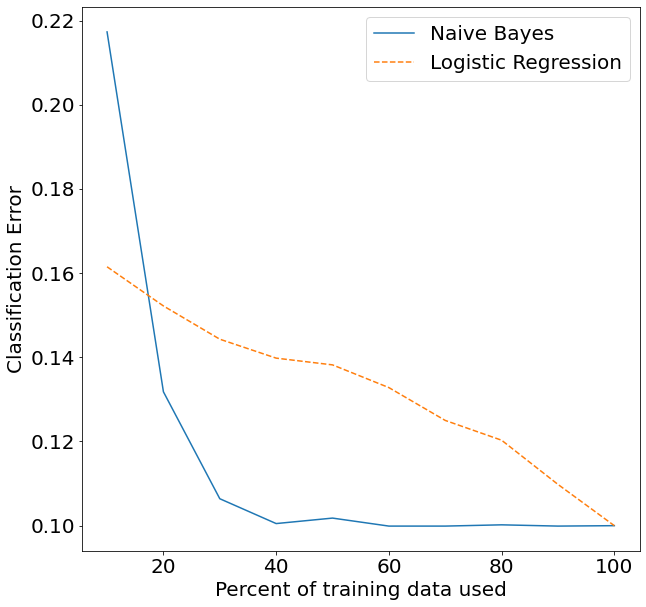

In [319]:
nbc = NBC(feature_types=['b'] * number_of_columns)
lr = LogisticRegression()
nbcres, lrres = compareNBCvsLR(nbc, lr, X, y, num_runs=500)
makePlot(nbcres, lrres)

In [320]:
nbcres, lrres

(array([0.2173, 0.1318, 0.1064, 0.1005, 0.1018, 0.0999, 0.0999, 0.1002,
        0.0999, 0.1   ]),
 array([0.1615, 0.1522, 0.1443, 0.1398, 0.1382, 0.1328, 0.125 , 0.1203,
        0.1098, 0.1   ]))

**Short Report**

For pre-processing the data the first step that was taken, was to undersample the dataset to 100 as required. To do this, the class proportion was taken into account. Since 62% of the data were of class 'democrat' and 38% was of class 'republican', it was decided as a way to balance the dataset to take 50 of each class (the dataset was shuffled before taking the data for each class). Next, due to some missing values, the next step was to clean the dataset and replace the missing values. To do this, for each class and for each attribute, the frequency of values was calculated and the missing values were filled using the most frequent value. After filling the missing values, labels and the values of the attributes were encoded to 0 or 1, since both the labels and attributes were binary. Moreover, the splitting of the data was performed in a way that the class distribution was conserved for both training and test datasets, and all the classes are included in both training and test datasets.

Through the comparison, it can be observed that the Logistic Regression line meets the naive bayes line early in the plot. It can be also observed that both classifiers achieved the same error at the end (0.10), using the whole dataset. Naive Bayes has the same trend as in the previous trend, a sharp decrease in error in the early dataset increaments and also, after 60% there was no change in the resulting error. On the other hand, Logistic Regression had a more gradual decrease, almost linear. Logistic Regression can achieve better results using very small dataset (using 10% of the training dataset). 